# Transformer



In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

基于位置的前馈网络

# Transformer Encoder Layer
```python
X = MultiHeadAttention(X, X, X)  # 自注意力
X = AddNorm(X)                   # 残差+层归一化
X = PositionWiseFFN(X)           # 位置-wise前馈网络
X = AddNorm(X)                   # 残差+层归一化
```

In [2]:
'''
X: (batch, seq_len, ffn_num_input)
   ↓ dense1 (线性变换)
(batch, seq_len, ffn_num_hiddens)
   ↓ relu (非线性激活)
(batch, seq_len, ffn_num_hiddens)
   ↓ dense2 (线性变换)
输出: (batch, seq_len, ffn_num_outputs)
'''
# 作用：对序列中每个位置（词元）的表示向量独立进行两次线性变换+ReLU激活
# 位置-wise"的含义：每个词元的变换不依赖其他位置，共享同一套参数
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    '''
    ffn_num_input：输入特征维度（如256）
    ffn_num_hiddens：隐藏层维度（通常为输入的4倍，如1024），这是模型的"扩展"部分
    ffn_num_outputs：输出特征维度（通常等于ffn_num_input，保持残差连接一致性）
    '''
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

改变张量的最里层维度的尺寸

In [3]:
'''
ffn_num_input=4：输入特征维度
ffn_num_hiddens=4：隐藏层维度（扩展后再压缩）
ffn_num_outputs=8：输出特征维度（** 注意 **：通常与输入一致，但这里设为8用于测试）
内部网络结构：
dense1：(4→4)线性层
relu：ReLU激活
dense2：(4→8)线性层
'''
ffn = PositionWiseFFN(4, 4, 8)
# 设置为评估模式
ffn.eval()
'''
形状:(batch=2,seq_len=3,feature=4);值:所有元素为1
输入: (2,3,4)
X → dense1: (2, 3, 4) @ W1(4,4) + b1 → (2, 3, 4)  # 线性变换
  → relu: max(0, X) → (2, 3, 4)  # 非线性激活（正值不变）
  → dense2: (2, 3, 4) @ W2(4,8) + b2 → (2, 3, 8)  # 输出变换
输出:(2,3,8)
[0]:取第一个批次样本;结果形状: (3,8)  # 3个词元，每个8维特征
数值计算示例（假设无偏置）
若权重矩阵随机初始化，且输入全为1：
dense1 输出：每个元素=sum(4个1 × 权重)=4个权重的和
relu输出：与dense1相同（全为正数）
dense2输出：每个元素=sum(4个dense1输出 × 权重)
'''
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.5757,  0.3157,  0.1610, -0.3407,  0.8124, -0.9005,  0.1504, -0.5822],
        [-0.5757,  0.3157,  0.1610, -0.3407,  0.8124, -0.9005,  0.1504, -0.5822],
        [-0.5757,  0.3157,  0.1610, -0.3407,  0.8124, -0.9005,  0.1504, -0.5822]],
       grad_fn=<SelectBackward0>)

对比不同维度的层规范化和批量规范化的效果

| 特性          | `LayerNorm(2)`      | `BatchNorm1d(2)` |
| :---------- | :------------------ | :--------------- |
| **归一化维度**   | **每个样本内部**（按特征维度）   | **整个批次**（按样本维度）  |
| **计算均值/方差** | 在特征维度（2）上计算         | 在批维度（样本数）上计算     |
| **适用场景**    | Transformer（序列长度变化） | CNN（固定特征图）       |


In [4]:
ln = nn.LayerNorm(2) # 对最后一个维度（特征维度）归一化(行计算)
bn = nn.BatchNorm1d(2) # 对第一个维度（批维度）归一化，特征数为2(列计算)
# X: (batch=2,features=2);样本0:[1,2];样本1:[2,3]
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


使用残差连接和层规范化

In [5]:
# Add：残差连接（self.dropout(Y)+X）;Norm：层归一化（self.ln(...)）
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    '''
    normalized_shape：层归一化的形状（通常是最后一个维度，如num_hiddens）
    dropout：dropout比率（防止过拟合）
    self.ln：层归一化实例（对每个样本的特征维度归一化）
    '''
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    '''
    self.dropout(Y)：对子层输出Y应用dropout
    +X ：与输入X相加（ 残差连接）
    self.ln(...)：对相加结果进行层归一化
    '''
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

加法操作后输出张量的形状相同

**输入：<br>**
```python
X = torch.ones((2, 3, 4))：形状为(batch=2, dim1=3, dim2=4)的全1张量
Y = torch.ones((2, 3, 4))：与X形状相同的全1张量
```
**计算过程：**
```Python
# 在AddNorm.forward内部:
self.dropout(Y) + X  # Y + X = 全1 + 全1 = 全2（形状仍为(2,3,4)）
self.ln(...)          # 对最后两个维度[3,4]进行层归一化
```
LayerNorm归一化逻辑：
将输入视为(..., 3, 4)，即每个大小为3×4=12的切片独立归一化,输入有2个这样的切片（batch维度=2）,每个切片计算均值和方差，然后标准化,输出形状不变：(2,3,4)<br>
**输出形状**
```Python
torch.Size([2, 3, 4])
```
**关键点：**
- 形状守恒：AddNorm不会改变输入张量的形状
- 残差连接前提：X和Y必须形状相同才能相加
- 归一化作用：不改变形状，只调整数值分布
**典型Transformer用法对比**
```Python
# 实际项目中（只对特征维度归一化）
add_norm = AddNorm(normalized_shape=256, dropout=0.1)  
# 输入: (batch, seq_len, 256) → 输出: (batch, seq_len, 256)
```
测试代码的特殊性：使用[3, 4]是为了演示归一化多维特征的能力，但在NLP中通常只归一化最后一个特征维度。


In [6]:
'''
normalized_shape=[3,4]：层归一化将对输入张量的最后两个维度（大小为3和4）进行归一化
dropout=0.5：在残差连接前应用50%的dropout（但eval()模式下会关闭）
⚠️ 注意：在标准的Transformer中，normalized_shape通常是单个整数（如特征维度num_hiddens），这里使用[3,4]是为了测试多维特征的归一化
'''
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval() # 评估模式（关闭dropout）
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

实现编码器中的一个层

| 设计元素                 | 作用                         | 解决的问题    |
| :------------------- | :------------------------- | :------- |
| **残差连接** (`+ X`)     | 保留原始信息，让梯度直接回传             | 深层网络梯度消失 |
| **层归一化** (`ln`)      | 稳定分布，减少内部协变量偏移             | 训练不稳定    |
| **顺序** (先子层后AddNorm) | Post-LN结构（原始Transformer设计） | 子层直接学习残差 |


## 数据流分步解析：
**第一步：多头自注意力 + 残差连接 + 层归一化<br>**
```Python
Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
# 1. X 作为Q, K, V输入到多头自注意力
# 2. attention输出与X进行残差连接（Y = dropout(attention(X)) + X）
# 3. 对结果进行层归一化
```
**关键细节：**
- 自注意力：queries=X, keys=X, values=X，表示自注意力（每个位置关注序列中所有位置）
- valid_lens：屏蔽填充位置，防止注意力集中在无效词元上
**第二步：前馈网络 + 残差连接 + 层归一化**
```Python
return self.addnorm2(Y, self.ffn(Y))
# 1. Y输入到前馈网络（对每个位置独立做MLP）
# 2. ffn输出与Y进行残差连接
# 3. 对结果进行层归一化，作为最终输出
```
**完整数据流与形状变化**
假设输入 X 形状为 (batch=32, seq_len=10, num_hiddens=256)：
```Python
# 输入 X: (32, 10, 256)

# 1. 多头自注意力
attention_output = self.attention(X, X, X, valid_lens)
# 输出: (32, 10, 256)

# 2. AddNorm1 (残差+层归一化)
Y = addnorm1(X, attention_output)  # X + attention_output 后归一化
# 输出: (32, 10, 256)  # 形状不变

# 3. 前馈网络
ffn_output = self.ffn(Y)  # 每个位置独立通过MLP: 256→512→256
# 输出: (32, 10, 256)  # 形状不变

# 4. AddNorm2 (残差+层归一化)
output = addnorm2(Y, ffn_output)  # Y + ffn_output 后归一化
# 最终输出: (32, 10, 256)
```
**为什么需要两个AddNorm？**<br>
Transformer采用残差连接解决深层网络梯度消失问题：
- 子层1：多头自注意力（捕获序列依赖）
- 子层2：前馈网络（增强非线性表达能力）
每个子层后都加残差连接，形成"子层输出 = 子层输入 + 子层变换"的结构，让梯度可以直接回传。<br>
**在Transformer中的位置**<br>
多个EncoderBlock堆叠形成完整Encoder：
```Python
encoder = nn.Sequential(
    nn.Embedding(vocab_size, num_hiddens),
    PositionalEncoding(num_hiddens, dropout),
    EncoderBlock(...),  # 第1层
    EncoderBlock(...),  # 第2层
    ...,
    EncoderBlock(...)   # 第N层（通常N=6或12）
)
```

In [7]:
'''
key_size,query_size, value_size：输入到多头注意力的K/Q/V维度
num_hiddens：投影后的统一维度（也是输出维度）
norm_shape：层归一化的形状（通常是num_hiddens）
ffn_num_input：前馈网络的输入维度（通常等于num_hiddens）
ffn_num_hiddens：前馈网络隐藏层维度（通常是num_hiddens的4倍）
num_heads：多头注意力的头数
dropout：dropout比率
use_bias：是否在投影层使用偏置
'''
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias) # 多头自注意力
        self.addnorm1 = AddNorm(norm_shape, dropout) # 第一个残差连接+层归一化
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens) # 位置感知前馈网络
        self.addnorm2 = AddNorm(norm_shape, dropout) # 第二个残差连接+层归一化

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

Transformer编码器中的任何层都不会改变其输入的形状

```Python
encoder_blk(X, valid_lens).shape
```
**内部计算流程与形状变化：**<br>
**阶段1：多头自注意力**（Masked）
```Python
# X → MultiHeadAttention(X,X,X,valid_lens)
# 输入: (2, 100, 24)
# → 投影: (2, 100, 24)
# → 分头: (16, 100, 3)  # 2×8=16, 24/8=3
# → 注意力: (16, 100, 3)  # valid_lens屏蔽填充位置
# → 合头: (2, 100, 24)
# → 输出投影: (2, 100, 24)
attention_out: (2, 100, 24)
```
**阶段2：AddNorm1**
```Python
# attention_out + X (残差连接) → LayerNorm
# 输入: (2, 100, 24) + (2, 100, 24)
# 输出: (2, 100, 24)
Y: (2, 100, 24)
```
**阶段3：前馈网络**
```Python
# Y → PositionWiseFFN(Y)
# → dense1: (2, 100, 24) → (2, 100, 48)
# → relu: (2, 100, 48)
# → dense2: (2, 100, 48) → (2, 100, 24)
ffn_out: (2, 100, 24)
```
**阶段4：AddNorm2**
```Python
# ffn_out + Y (残差连接) → LayerNorm
# 输入: (2, 100, 24) + (2, 100, 24)
# 输出: (2, 100, 24)
output: (2, 100, 24)
```
**输出结果**
```Python
torch.Size([2, 100, 24])
```

In [8]:
# 形状:(batch=2,seq_len=100,feature=24);模拟2个样本，每个样本100个词元，每个词元24维特征
X = torch.ones((2, 100, 24))
# 两个样本的有效长度分别为3和2
# 样本0: 前3个词元有效，后97个是<padding>;样本1: 前2个词元有效，后98个是<padding>
valid_lens = torch.tensor([3, 2])
# ffn_num_hiddens=48通常是num_hiddens的2-4倍，这是Transformer中常见的扩展比例
encoder_blk = EncoderBlock(24, # Key输入维度
                           24, # Query输入维度
                           24, # Value输入维度
                           24, # 投影后统一维度
                           [100, 24], # LayerNorm对最后两个维度[100,24]归一化
                           24, # 前馈网络输入维度
                           48, # 前馈网络隐藏层维度（扩展为2倍）
                           8, # 8头注意力
                           0.5) # Dropout比率
encoder_blk.eval() # 设置为评估模式
encoder_blk(X, valid_lens).shape # 前向传播并检查输出形状

torch.Size([2, 100, 24])

Transformer编码器

**完整数据流追踪**<br>
**输入：**

```python
X: (batch, seq_len)  # 词索引，如 [[5, 3, 1, 0, 0], ...]
valid_lens: (batch,)  # 有效长度，如 [3, 2, ...]
```
**变换过程：**

```python
X: (batch, seq_len) 
→ embedding: (batch, seq_len, num_hiddens)  # 如512维
→ 缩放: (batch, seq_len, num_hiddens) * sqrt(512)
→ pos_encoding: (batch, seq_len, num_hiddens)

→ block0: (batch, seq_len, num_hiddens)  # 第1个编码器块
→ block1: (batch, seq_len, num_hiddens)  # 第2个编码器块

→ block5: (batch, seq_len, num_hiddens)  # 第6个编码器块（num_layers=6）

Output: (batch, seq_len, num_hiddens)  # 最终编码表示
```

```txt
EncoderBlock
└─ MultiHeadAttention (self.attention)
   └─ DotProductAttention (self.attention.attention)
      └─ attention_weights (self.attention.attention.attention_weights)
```
- 第一层：blk.attention → 多头注意力（管理多头并行）
- 第二层：blk.attention.attention → 实际计算缩放点积的实例
- 第三层：blk.attention.attention.attention_weights → 存储的注意力分数矩阵

In [9]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    '''
    vocab_size：源语言词汇表大小
    key_size/query_size/value_size：Q/K/V的输入维度（通常等于num_hiddens）
    num_hiddens：嵌入和隐藏层维度（Transformer-base设为512）
    num_layers：编码器块堆叠层数（通常6层）
    dropout：Dropout比率
    '''
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        # 构建编码器组件
        self.num_hiddens = num_hiddens 
        self.embedding = nn.Embedding(vocab_size, num_hiddens) # 词嵌入层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) # 位置编码
        # 堆叠编码器块:使用nn.Sequential容器管理多个编码器块,每个块命名为block0, block1,...便于后续访问
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias)) # 添加num_layers个编码器块
    # 前向传播
    def forward(self, X, valid_lens, *args):
        '''
        步骤1：嵌入+位置编码（含缩放）
        self.embedding(X)：将词索引转换为(batch,seq_len,num_hiddens)的嵌入向量
        * math.sqrt(self.num_hiddens)：缩放嵌入向量（论文细节：补偿残差连接导致的梯度缩小）
        self.pos_encoding(...)：注入位置信息
        '''
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        '''
        步骤2：初始化注意力权重存储:为每个编码器块预留空间存储注意力权重（用于可视化或分析）
        '''
        self.attention_weights = [None] * len(self.blks) # 创建空列表
        '''
        步骤3：顺序通过编码器块
        blk：当前第i个EncoderBlock实例
        blk.attention：该块内的多头注意力层（MultiHeadAttention）
        blk.attention.attention：多头注意力内部的缩放点积注意力（DotProductAttention）
        blk.attention.attention.attention_weights：该注意力层计算出的原始权重矩阵
        '''
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens) # 通过第i个编码器块
            self.attention_weights[
                i] = blk.attention.attention.attention_weights # 从深层访问第i个块的注意力权重
        # 步骤4：返回编码结果:(batch,seq_len,num_hiddens)
        return X 

创建一个两层的Transformer编码器

## 内部流程与形状变化
**阶段1：嵌入 + 位置编码**
```Python
# 输入: (2, 100)
X = embedding(X) → (2, 100, 24)  # 词索引→嵌入向量
X = X * sqrt(24) → (2, 100, 24)   # 缩放嵌入向量
X = pos_encoding(X) → (2, 100, 24) # 注入位置信息
```
**阶段2：编码器块堆叠（循环2次）**
```Python
# 第0个EncoderBlock
X = block0(X, valid_lens) → (2, 100, 24)
# 存储权重: self.attention_weights[0] = (16, 100, 100)

# 第1个EncoderBlock  
X = block1(X, valid_lens) → (2, 100, 24)
# 存储权重: self.attention_weights[1] = (16, 100, 100)
```
**阶段3：返回最终编码**
```Python
return X  # 形状: (2, 100, 24)
注：16 = 2 (batch) × 8 (heads)，每个注意力权重矩阵形状为(16, 100, 100)
```
**输出结果**
```Python
torch.Size([2, 100, 24])
```

In [10]:
# 实际Transformer使用num_hiddens=512,num_layers=6
encoder = TransformerEncoder(
    200, # vocab_size=200（源语言词汇表大小）
    24, # key_size=24（Key输入维度）
    24, # query_size=24（Query输入维度） 
    24, # value_size=24（Value输入维度）
    24, # num_hiddens=24（投影后统一维度）
    [100, 24], # norm_shape=[100,24]（LayerNorm归一化最后两个维度）
    24, # ffn_num_input=24（前馈网络输入维度）
    48, # ffn_num_hiddens=48（前馈隐藏层，扩展2倍）
    8, # num_heads=8（8头注意力）
    2, # num_layers=2（堆叠2个编码器块）
    0.5) # dropout=0.5
encoder.eval() # 评估模式
# 输入X：(batch=2,seq_len=100)，全1作为占位符
# valid_lens：假设已定义为torch.tensor([3,2])，表示样本0前3个词有效，样本1前2个词有效
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

Transformer解码器也是由多个相同的层组成

| 阶段       | `state[2][self.i]` | `key_values` | 结果    |
| :------- | :----------------- | :----------- | :---- |
| **首次调用** | `None`             | `X`（当前输入）    | 初始化缓存 |
| **后续调用** | 历史缓存               | `cat(缓存, X)` | 扩展缓存  |


In [11]:
'''
X: (batch, seq_len, num_hiddens)  # 目标语言词嵌入（教师强制）
enc_outputs: (batch, src_len, num_hiddens)  # 编码器输出
enc_valid_lens: (batch,)  # 源句有效长度

→ attention1 (掩蔽自回归): (batch, seq_len, num_hiddens)
→ addnorm1: (batch, seq_len, num_hiddens)
→ attention2 (编码器-解码器): (batch, seq_len, num_hiddens)
→ addnorm2: (batch, seq_len, num_hiddens)
→ ffn: (batch, seq_len, num_hiddens)
→ addnorm3: (batch, seq_len, num_hiddens)

Output: (batch, seq_len, num_hiddens), state
'''
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs): # i：解码器块的索引（0,1,2,...），用于访问状态缓存
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        '''
        第一个多头自注意力（带掩码）
        实现 掩蔽自注意力（Causal Masked Self-Attention）
        每个位置只能关注之前的位置（因果掩码），防止信息泄露，掩蔽自注意力（自回归）
        关键特性：训练时通过dec_valid_lens屏蔽未来词，确保位置i只能看到≤i的词
        使用场景：解码器生成第i个词时，只能依赖已生成的词
        '''
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout) # 在自注意力后
        '''
        第二个多头注意力（编码器-解码器）
        解码器查询编码器的输出，实现源-目标对齐，编码器-解码器注意力
        作用：实现编码器-解码器注意力（Cross-Attention）
        Query：来自自注意力输出（解码器侧）
        Key/Value：来自编码器输出（源语言侧）
        关键：使解码器每个位置都能关注源句相关部分，实现翻译对齐
        '''
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout) # 在编码器-解码器注意力后
        '''
        位置感知前馈网络（FFN）
        作用：对每个位置独立做非线性变换（MLP）
        扩展-收缩：通常ffn_num_hiddens是num_hiddens的2-4倍（如48→24）
        '''
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout) # 在FFN后
    '''
    state：三元组 (enc_outputs,enc_valid_lens,key_value_cache)
    enc_outputs：编码器输出，作为attention2的Key和Value
    enc_valid_lens：编码器有效长度，用于屏蔽源句填充
    '''
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        '''
        1. 键值缓存机制
        作用：在推理时，缓存之前的Key和Value，避免重复计算。
        state[2]：列表，每个元素对应一个解码器块的缓存;self.i：当前块索引，访问对应缓存
        训练时：state[2][i]为None，直接使用当前X;推理时：缓存历史Key/Value，与新输入X拼接
        '''
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        '''
        2. 因果掩码
        训练阶段（self.training=True）：生成dec_valid_lens=[[1,2,3,...,seq_len], ...]，形状 (batch,seq_len)
        强制每个位置只能关注前缀（位置i只能看0~i），实现自回归
        第1个词只能看自己，第2个词看前2个，第3个词看前3个...
        推理阶段 （self.training=False）：dec_valid_lens=None，因为生成是顺序的，天然只能看到历史
        '''
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        '''
        3. 掩蔽自注意力
        X：当前输入（Query）
        key_values：缓存的Key/Value（训练时是X，推理时是历史拼接）;dec_valid_lens：因果掩码，确保自回归
        输出：经过掩蔽的自注意力结果
        '''
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        '''
        4. 编码器-解码器注意力
        Query：来自自注意力输出Y（解码器侧）;Key/Value：来自编码器输出enc_outputs（源语言侧）
        作用 ：解码器每个位置关注源句相关部分，实现翻译对齐
        '''
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        '''
        5. 前馈网络
        self.ffn(Z)：位置感知前馈网络变换
        self.addnorm3(...)：残差连接+层归一化
        返回值：(输出, 更新后的state)
        state包含新的key_values缓存，供下一个时间步使用
        '''
        return self.addnorm3(Z, self.ffn(Z)), state

编码器和解码器的特征维度都是`num_hiddens`

**阶段1：自注意力（带缓存）**
```Python
# state[2][0] is None → key_values = X (2, 100, 24)
# state[2][0] = X  # 缓存当前输入
# dec_valid_lens = None (eval模式)
X2 = attention1(X, key_values, key_values, None)  # (2, 100, 24)
Y = addnorm1(X, X2)  # (2, 100, 24)
```
**阶段2：交叉注意力**
```Python
# Query: Y (2, 100, 24)
# Key/Value: enc_outputs (2, 100, 24)
# enc_valid_lens: [3, 2]
Y2 = attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)  # (2, 100, 24)
Z = addnorm2(Y, Y2)  # (2, 100, 24)
```
**阶段3：前馈网络**
```Python
output = addnorm3(Z, ffn(Z))  # (2, 100, 24)
return output, state  # state[2][0] 已更新为 X
```
**输出结果**
```Python
torch.Size([2, 100, 24])
```

In [12]:
# 1. 创建解码器块
# 索引i=0：这是第0个解码器块（状态缓存将使用state[2][0]）
# 参数匹配：维度与编码器块一致，确保注意力机制兼容
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24)) # (batch=2,seq_len=100,feature=24)
'''
state[0] ：编码器输出 (2,100,24)，作为交叉注意力的Key/Value
state[1]：假设valid_lens=torch.tensor([3,2])，屏蔽源句填充
state[2]：列表[None]，初始时第0块缓存为空
'''
state = [encoder_blk(X, valid_lens), # state[0]:编码器输出
         valid_lens, # state[1]:编码器有效长度 
         [None]] # state[2]:键值缓存列表
# 解码器块前向传播
'''
decoder_blk(X, state)[0].shape
# └─────────────┬─────────────┘
#      返回元组 (output, state)
#           │
#           └─ [0] 取第一个元素 output
#                │
#                └─ .shape 获取 output 的形状
'''
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Transformer解码器

**完整数据流追踪**<br>
**训练阶段（self.training=True）：**
```txt
X: (batch, tgt_len)  # 目标序列（教师强制）
state: [enc_out, enc_valid_lens, [None]*2]

→ 嵌入+位置编码: (batch, tgt_len, num_hiddens)
→ block0: (batch, tgt_len, num_hiddens)  # 第0层解码
→ block1: (batch, tgt_len, num_hiddens)  # 第1层解码
→ dense: (batch, tgt_len, vocab_size)    # 生成logits
```
**输出: (logits, state)**
**推理阶段（self.training=False）：**
```txt
逐个生成词元，state[2]逐步缓存历史Key/Value
每步输出: (batch, 1, vocab_size)  # 当前位置的预测
```

基本语法对比
**不使用@property**：
```Python
class Decoder:
    def attention_weights(self):
        return self._attention_weights

# 调用时必须加括号
weights = decoder.attention_weights()  # 方法调用
```
**使用@property**：
```Python
class Decoder:
    @property
    def attention_weights(self):
        return self._attention_weights

# 调用时像访问属性一样（无需括号）
weights = decoder.attention_weights  # 属性访问
```

In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    # 参数：与编码器基本相同，但num_layers指解码器块堆叠层数
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers # 解码器块数量
        self.embedding = nn.Embedding(vocab_size, num_hiddens) # 目标语言词嵌入
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) # 位置编码
        '''
        nn.Sequential是一个有序的模块容器，可存储多个子模块
        自动注册：添加到Sequential中的子模块会自动注册到父模型，其参数会被model.parameters()捕获
        设备迁移：调用model.to(device)时，Sequential内所有子模块会自动迁移
        '''
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                # 每个DecoderBlock接收唯一索引i，用于访问对应的键值缓存
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i)) # 传递索引i给每个块
        self.dense = nn.Linear(num_hiddens, vocab_size) # 解码为词表logits

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        '''
        state[0]：编码器输出 (batch,src_len,num_hiddens)
        state[1]：编码器有效长度(batch,)，屏蔽源句填充
        state[2]：列表[None, None, ...,None]，长度为num_layers，每个元素存储对应解码器块的键值缓存
        '''
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    # 前向传播
    # 输入处理（同编码器）：词嵌入+缩放+位置编码→(batch,tgt_len,num_hiddens)
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        '''
        创建2×N矩阵：2行分别存储两种注意力，N列对应num_layers层
        结构:[[att1_layer0,att1_layer1,...], [att2_layer0,att2_layer1,...]]
        '''
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state) # 通过第i个块
            '''
            提取两种注意力权重
            blk.attention1.attention.attention_weights深入三层访问权重
            blk.attention1→第i块的掩蔽自注意力（MultiHeadAttention实例）
            .attention→其内部的DotProductAttention实例
            .attention_weights→该实例存储的权重矩阵
            '''
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights # 自注意力
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights # 交叉注意力
        # X:(batch,tgt_len,num_hiddens)→dense→(batch,tgt_len,vocab_size)
        # logits：返回词表上的未归一化概率分布;state：返回更新后的状态（含键值缓存，供下一步使用）
        return self.dense(X), state
    '''
    用途：外部接口，训练/推理后可通过decoder.attention_weights访问所有层的注意力矩阵
    attention_weights[0]：所有层的自注意力权重
    attention_weights[1]：所有层的交叉注意力权重
    '''
    @property
    def attention_weights(self):
        return self._attention_weights

训练

内部流程：
1. 教师强制：解码器输入是目标序列右移一位（<bos>开头）
2. 掩蔽损失：只计算有效长度内词元损失，忽略<pad>
3. Adam优化：学习率0.005
4. GPU加速：自动使用CUDA
5. 梯度裁剪：防止梯度爆炸（阈值=1）

loss 0.033, 6888.7 tokens/sec on cuda:0


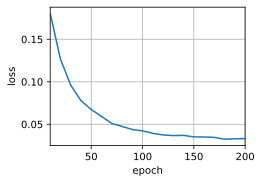

In [14]:
'''
num_hiddens=32：隐藏层维度（实际Transformer用512，这里简化）
num_layers=2：编码器/解码器各2层（标准模型用6层）
dropout=0.1：10%随机失活防止过拟合
batch_size=64：每批64个句子对
num_steps=10：句子最大长度（截断/填充到10个词元）
'''
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
'''
lr=0.005：Adam学习率（标准Transformer用0.0001）
num_epochs=200：训练200轮
device：自动选择GPU加速
'''
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
'''
ffn_num_hiddens=64：前馈网络隐藏层（扩展2倍）
num_heads=4：4头注意力（标准用8头）
norm_shape=[32]：LayerNorm仅对特征维度归一化
'''
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
'''
train_iter：训练迭代器，返回 (源批,源长度,目标批,目标长度)
src_vocab：源语言词汇表（英语，约10000词）
tgt_vocab：目标语言词汇表（法语，约10000词）
num_steps=10：句子截断/填充到10个词元（含<bos>,<eos>）
'''
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
# 创建Transformer编码器,结构：Embedding→PositionalEncoding→2×EncoderBlock
# 作用：将源语言句子编码为隐藏表示
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
# 创建Transformer解码器,结构：Embedding→PositionalEncoding→2×DecoderBlock→Linear
# 特点：包含掩蔽自注意力 + 交叉注意力 + FFN
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
# 组装编码器-解码器,封装：组合成端到端Seq2Seq模型,接口：标准forward(enc_X,dec_X,enc_valid_lens)方法
net = d2l.EncoderDecoder(encoder, decoder)
# 训练模型
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

将一些英语句子翻译成法语

整体流程总结
1. 输入：英语句子（字符串）
2. 分词：按空格拆分 → 词元索引 → <bos>开头
3. 编码：Transformer编码器生成源语言表示
4. 解码：自回归生成目标语言词元（<bos> → 词1 → 词2 → ... → <eos>）
5. 输出：拼接词元为句子
6. 评估：BLEU量化翻译质量

In [15]:
# engs：4个英语测试句子（包含缩写和标点）；fras：对应的标准法语参考译文（用于计算BLEU分数）
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
'''
predict_seq2seq：核心预测函数
net：训练好的Transformer模型
eng：输入英语句子
src_vocab/tgt_vocab：源/目标语言词汇表
num_steps：最大生成长度（如10）
device：GPU/CPU
True：保存注意力权重
返回值：
translation：模型生成的法语句子（字符串）
dec_attention_weight_seq：解码器每步的 注意力权重列表（用于可视化）
'''
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    '''
    d2l.bleu(translation,fra,k=2)：计算翻译结果与参考译文的BLEU分数
    k=2：使用2-gram（二元词组）匹配
    返回值：0到1之间，越接近1质量越好
    .3f：保留3位小数
    '''
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


可视化Transformer的注意力权重

In [16]:
'''
1. net.encoder.attention_weights:(batch_size*num_heads,seq_len,seq_len)
类型：列表，长度=num_layers（编码器块数量）
每个元素：一个EncoderBlock的注意力权重张量
2. torch.cat(...,0)：跨层连接
作用：在第0维（batch-head维度）连接所有层的权重
结果形状：(num_layers*batch_size*num_heads,seq_len,seq_len)
3. .reshape(...)：重塑为分析维度,(num_layers,num_heads, -1,num_steps)
参数：
num_layers：编码器层数
num_heads：注意力头数
-1：自动推断，值为 batch_size*seq_len
num_steps：源序列长度
4. enc_attention_weights.shape:显示最终形状，用于验证重塑正确性
'''
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

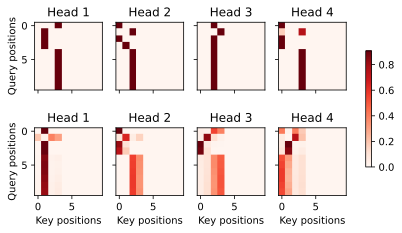

In [17]:
'''
热力图含义：
颜色深浅：注意力权重值（0到1）
对角线亮：每个词关注自己（自注意力特性）
模式差异：不同头关注不同关系：
Head1：可能关注相邻词（局部依赖）
Head2：可能关注相同词（复制机制）
Head3：可能关注关键动词（句法角色）
Head4：可能长距离跳跃（语义关联）
典型观察模式
低层（Layer 0）：关注局部语法（相邻词）
高层（Layer 5）：关注长距离语义（主谓一致）
不同头：不同头学习不同语言模式，如指代、时态、句法结构
'''
d2l.show_heatmaps(
    # 作用：将注意力权重张量从GPU移动到CPU,原因：matplotlib绘图库只能在CPU上处理数据
    enc_attention_weights.cpu(), 
    xlabel='Key positions', # 横轴：被关注的词元位置（如源句中的词）
    ylabel='Query positions', # 纵轴：发起关注的词元位置（如目标句中的词）
    # 生成: ['Head 1','Head 2','Head 3','Head 4']，对应4个注意力头（num_heads=4）
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作

In [18]:
'''
dec_attention_weight_seq：列表，长度=目标序列长度（生成的词数）
step：单个时间步的权重，是元组(attn1, attn2)（自注意力和交叉注意力）
attn：列表，长度=2（两种注意力类型）
blk：列表，长度=num_layers（每层一个权重）
head：列表，长度=num_heads（每个头一个权重矩阵）
访问路径：dec_attention_weight_seq[time_step][attn_type][layer][head]
提取逻辑：
head[0]：每个头的权重张量形状 (batch*heads,1,src_len)，取第0个batch-head切片
.tolist()：转换为Python列表，便于后续处理
结果：dec_attention_weights_2d是一维列表，每个元素是一个head的权重列表，总长度=目标词数×2×num_layers×num_heads
dec_attention_weight_seq: 列表，长度=目标词数（如7）
└─ step: 元组 (attn1, attn2)
   ├─ attn: 列表，长度=2（两种注意力）
   │  ├─ blk: 列表，长度=num_layers（2层）
   │  │  └─ head: 列表，长度=num_heads（4个头）
   │  │     └─ head[0]: 张量，形状 (batch*heads, 1, seq_len)
'''
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
'''
pd.DataFrame(...)：将列表转换为DataFrame，自动对齐为二维矩阵
.fillna(0.0)：填充因序列长度不一导致的缺失值（NaN）
.value：获取NumPy数组
torch.tensor(...)：转换为PyTorch张量
结果：dec_attention_weights_filled 形状(总元素数,最大长度)，如(800,10)
'''
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
'''
-1：自动推断为目标词数×batch_size（如64个样本×10词=640）
2：两种注意力类型（0=自注意力，1=交叉注意力）
num_layers：解码器层数
num_heads：注意力头数
num_steps：源/目标序列长度
'''
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
'''
1：注意力类型维度（0或1）
2：层数维度
3：头数维度
0：批次数×词数维度
4：序列长度维度
'''
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

**为什么要切片 [:len(translation.split()) + 1]？**<br>
**1. 去除填充（Padding）**
Transformer生成时设置最大长度 num_steps（如10）：若生成 "va !"，实际长度 = 2词 + <eos> = 3。剩余7个位置是 <pad>，注意力权重无意义
**对比：**
```python
# 不切片: 显示10×10矩阵，后7列是填充空白
# 切片[:3]: 仅显示3×3有效区域，聚焦实际生成的词
```
**2. +1 的作用**
+1是为了包含<eos>（序列结束标记）：<br>
```python
translation = "va !"
translation.split() → ["va", "!"] → len = 2
len + 1 = 3  # 包含位置: <bos>, "va", "!" (<eos>在最后一个位置)
```
**完整词元序列**（内部表示）：
```python
位置 0: <bos>   (解码器输入)
位置 1: "va"    (生成第1个词)
位置 2: "!"     (生成第2个词，即<eos>)
切片: [:3] → 保留前3个位置
```
**3. 可视化清晰性**<br>
**不切片**：热力图显示10列，后7列空白或噪声，干扰分析<br>
**切片后**：仅显示实际生成的词，注意力模式清晰（如对角线）<br>
**切片效果示例**<br>
生成句子："go ." → "va !"<br>
**不切片（显示 num_steps=10）：**<br>
```python
Key positions: 0 1 2 3 4 5 6 7 8 9
               ■ ■ ■ □ □ □ □ □ □ □  ← 后7列是填充，无意义
Query pos 0:   ■ □ □ □ □ □ □ □ □ □
Query pos 1:   ■ ■ □ □ □ □ □ □ □ □
Query pos 2:   ■ ■ ■ □ □ □ □ □ □ □
...（7行空白）
```
**切片后（[:3]）：**<br>
```python
Key positions: 0 1 2
               ■ ■ ■  ← 仅3列，清晰展示实际生成过程
Query pos 0:   ■ □ □  # 生成<bos>，只关注自己
Query pos 1:   ■ ■ □  # 生成"va"，关注<bos>和自己
Query pos 2:   ■ ■ ■  # 生成"!"，关注全部历史
```
**验证自回归特性**<br>
正确模式：
- 第i行只能看到前i+1列（因果掩码生效）
- 对角线亮：每个词关注自己
- 第0行只有第0列亮：<bos>只能关注自己
如果不过滤填充：
- 后7列的空白会误导分析
- 可能误判为注意力失效
**为什么是 num_keys 维度切片？**
在自注意力中：
- Query：当前生成的词位置
- Key：历史所有词位置（包括自己）
- **num_keys**：源序列长度（输入侧）
- **num_queries**：目标序列长度（输出侧）<br>

对num_keys切片，确保只显示实际生成的历史词，而非填充的<pad>。

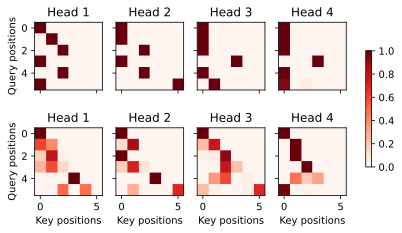

In [23]:
'''
dec_self_attention_weights形状：(num_layers,num_heads,num_queries,num_keys)
dim0：解码器层数（0, 1）
dim1：注意力头数（0, 1, 2, 3）
dim2：Query位置（生成第几个词）
dim3：Key位置（关注历史哪个词）
len(translation.split())+1： 保留有效长度+1（+1是为包含<eos>标记）
例如翻译为 "va !"，分词后长度=2，切片[:3]保留前3个位置（含<bos>或<eos>）
作用：去除因num_steps填充的空白部分，使热力图只显示实际生成的词
'''
'''
Key positions（横轴）：被关注的词元位置（目标句历史词）
如[<bos>,"va","!"] 的位置0,1,2
Query positions（纵轴）：发起关注的词元位置（当前生成的词）
生成第1个词时关注[<bos>];生成第2个词时关注 [<bos>,"va"]
'''
'''
num_heads=4：4个注意力头，每个子图展示一个头的模式
Head1：关注相邻词（局部依赖）
Head2：关注相同词（复制机制）
Head3：关注动词（句法角色）
Head4：关注主语（长距离依赖）
颜色：蓝色越深表示注意力权重越大
模式：对角线附近亮（每个词关注自己和相邻词）
差异：不同头关注不同位置
'''
d2l.show_heatmaps(
    
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
   
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

输出序列的查询不会与输入序列中填充位置的词元进行注意力计算

**典型问题诊断**<br>
**BLEU低 + 交叉注意力混乱**：
- 生成"va"时关注"."而非"go" → 编码器输出质量差或注意力失效
- 所有头模式相同 → 多头未学到差异化表示
**BLEU高 + 注意力对齐清晰**：
- 生成"va"时仅"go"列亮 → 模型正确学习词级对齐
- 不同头模式不同 → 多头有效捕获不同语言特征

In [24]:
d2l.show_heatmaps(
    '''
    数据：解码器的编码器-解码器注意力权重
    形状：(num_layers,num_heads,num_queries,num_keys)表示层、头、目标位置、源位置
    含义：每个目标词（Query）对源句每个词（Key）的关注度
    '''
    dec_inter_attention_weights, 
    # x轴：源句词元序列（被翻译的句子）;y轴：目标句词元序列（生成的翻译）
    xlabel='Key positions', # 横轴：源语言词位置
    ylabel='Query positions', # 纵轴：目标语言词位置
    # num_heads=4：4个注意力头，每个头学习不同对齐模式
    # 多头意义：不同头关注不同对齐关系（如主-主对齐、动-动对齐）
    titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

SyntaxError: invalid syntax (2840234917.py, line 7)